In [1]:
import numpy as np
import pdb
import torch
import torch.nn as nn
from torch_geometric.data import Data

from env.sys_admin import *
from gnn_model import GraphGNNModel

import sys
sys.path.append('/home/victorialena/rlkit')

import rlkit
# from rlkit.samplers.data_collector import MdpPathCollector
from path_collector import MdpPathCollector
from rlkit.torch.torch_rl_algorithm import TorchBatchRLAlgorithm

from any_replay_buffer import anyReplayBuffer
from dqn import DQNTrainer
from policies import *

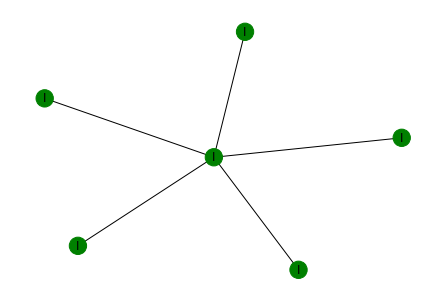

In [2]:
env = sysAdmin(nnodes=6, njobs=25)
x = env.reset(topology='star')
env.render()

```python
a = env.action_space.sample()
data, r, _, _ = env.step(a)
```

In [3]:
in_channels = len(load)+len(status)
out_channels = len(action)

In [4]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [5]:
from collections import OrderedDict

from torch.nn import Linear, ReLU
import torch.nn.functional as F

class sysAdminModel(nn.Module):
    
    def __init__(self, c_in, c_out, c_hidden=64, dp_rate_linear=0.5, **kwargs):
        
        super().__init__()
        
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(in_channels, c_hidden)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(c_hidden, out_channels)),
#             ('relu2', nn.ReLU()),
#             ('fc3', nn.Linear(c_hidden, out_channels)),
            ('act', nn.Softmax(dim=1))
        ]))

        self._device = 'cpu'

    def forward(self, x, edge_index):
        return self.model(x.to(self._device))
    
    def to(self, device):
        super().to(device)
        self._device = device

In [6]:
qf = sysAdminModel(in_channels, out_channels)
target_qf = sysAdminModel(in_channels, out_channels)

# qf = GraphGNNModel(in_channels, 256, out_channels, use_edge_weight=False)
# target_qf = GraphGNNModel(in_channels, 256, out_channels, use_edge_weight=False)

In [7]:
from rlkit.policies.base import Policy

class sysRolloutPolicy(nn.Module, Policy):
    def __init__(self, aspace, eps=0.05):
        super().__init__()
        self.eps = eps
        self.aspace = aspace

    def get_action(self, obs):
        if rand() < self.eps:
            return self.aspace.sample(), {}
        return torch.where(obs.x[:, 0]==status.dead, action.reboot, action.noop).cpu().detach().numpy(), {}


In [8]:
qf_criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf, format_data)
# expl_policy = sysRolloutPolicy(env.action_space)
expl_policy = epsilonGreedyPolicy(qf, format_data, env.action_space, eps=0.05)

```python
expl_policy = sysRolloutPolicy(env.action_space)
expl_path_collector = MdpPathCollector(env, expl_policy)
paths = expl_path_collector.collect_new_paths(1, 40, False)

for s, a, r, t in zip(paths[0]['observations'], paths[0]['actions'], 
                      paths[0]['rewards'], paths[0]['terminals']):
    print(s.x)
    print(a)
    print(r)
    print(t)
```

In [9]:
from torch.optim import Adam

In [10]:
expl_path_collector = MdpPathCollector(env, expl_policy)
eval_path_collector = MdpPathCollector(env, eval_policy)
replay_buffer = anyReplayBuffer(10000)
optimizer = Adam(qf.parameters(), lr=1E-4)

#### Reinforcement Learning

In [11]:
for i in range(100):
    paths = expl_path_collector.collect_new_paths(1000, 40, False)
    replay_buffer.add_paths(paths)
    
    qf.train(True)
    loss = []
    avg_r = []
    for _ in range(10):
        loss.clear()
        avg_r.clear()
        batch = replay_buffer.random_batch(512)
        rewards = torch.Tensor(batch['rewards']).unsqueeze(-1)
        terminals = torch.Tensor(batch['terminals'])
        actions = torch.Tensor(batch['actions'])

        obs = batch['observations']
        next_obs = batch['next_observations']
    
        ff = lambda x: target_qf(*x)
        out = torch.stack(list(map(ff, map(format_data, obs))), axis=0).cpu()
        target_q_values = out.max(-1).values
#         pdb.set_trace()
        y_target = rewards + (1. - terminals) * 0.95 * target_q_values
        
        ff = lambda x: qf(*x)
        out = torch.stack(list(map(ff, map(format_data, obs))), axis=0).cpu()
        
        actions_one_hot = F.one_hot(actions.to(torch.int64))
        y_pred = torch.sum(out * actions_one_hot, dim=-1)#.sum(1, keepdim=True)
        qf_loss = qf_criterion(y_pred, y_target)
        
        loss.append(qf_loss.item())
        avg_r.append(rewards.mean().item())
        
        optimizer.zero_grad()
        qf_loss.backward()
        optimizer.step()
    
    target_qf.load_state_dict(qf.state_dict())
    print("iter ", i, " -> loss: ", np.mean(loss), ", rewards: ", np.mean(avg_r))        

iter  0  -> loss:  4.007802963256836 , rewards:  -1.44482421875
iter  1  -> loss:  4.075602054595947 , rewards:  -1.47265625
iter  2  -> loss:  4.034618854522705 , rewards:  -1.47265625
iter  3  -> loss:  3.9768521785736084 , rewards:  -1.4599609375
iter  4  -> loss:  3.896735429763794 , rewards:  -1.44921875
iter  5  -> loss:  3.8800208568573 , rewards:  -1.45703125
iter  6  -> loss:  3.8534107208251953 , rewards:  -1.458984375
iter  7  -> loss:  3.374918222427368 , rewards:  -1.27880859375
iter  8  -> loss:  3.005838632583618 , rewards:  -1.13427734375
iter  9  -> loss:  2.6532323360443115 , rewards:  -0.99658203125
iter  10  -> loss:  2.4861133098602295 , rewards:  -0.93359375
iter  11  -> loss:  1.9483038187026978 , rewards:  -0.71044921875
iter  12  -> loss:  1.7945648431777954 , rewards:  -0.642578125
iter  13  -> loss:  1.277905821800232 , rewards:  -0.42724609375
iter  14  -> loss:  1.2084096670150757 , rewards:  -0.39794921875
iter  15  -> loss:  0.7195394039154053 , rewards: 

#### Supervised Learning

In [ ]:
for i in range(100):
    paths = expl_path_collector.collect_new_paths(100, 80, False)
    replay_buffer.add_paths(paths)
    
    qf.train(True)
    loss = []
    for _ in range(50):
        loss.clear()
        batch = replay_buffer.random_batch(256)
        rewards = torch.Tensor(batch['rewards']).unsqueeze(-1)
        terminals = torch.Tensor(batch['terminals'])
        actions = torch.Tensor(batch['actions'])

        obs = batch['observations']
        next_obs = batch['next_observations']
    
        ff = lambda x: qf(*x)
        out = torch.stack(list(map(ff, map(format_data, obs))), axis=0).cpu()        
        qf_loss = qf_criterion(out.swapaxes(1,2), actions.to(torch.int64))
        
        loss.append(qf_loss.item())
        
        optimizer.zero_grad()
        qf_loss.backward()
        optimizer.step()
        
    print("iter ", i, " -> loss: ", np.mean(loss))
    
    # test
    # qf.train(False)
        

```python
paths = expl_path_collector.collect_new_paths(10, 20, False)
```

In [ ]:
variant = dict(
    algorithm="DQN",
    version="normal",
    layer_size=256,
    replay_buffer_size=int(1E4),
    algorithm_kwargs=dict(
        num_epochs=300,
        num_eval_steps_per_epoch=500,
        num_trains_per_train_loop=100,
        num_expl_steps_per_train_loop=100,
        min_num_steps_before_training=100,
        max_path_length=100,
        batch_size=256,
    ),
    trainer_kwargs=dict(
        discount=0.99,
        learning_rate=1E-4,
    ),
)

trainer = DQNTrainer(qf=qf,
                     target_qf=target_qf,
                     qf_criterion=qf_criterion,
                     **variant['trainer_kwargs'],
                     format_data = format_data)

replay_buffer = anyReplayBuffer(variant['replay_buffer_size'])

algorithm = TorchBatchRLAlgorithm(
    trainer=trainer,
    exploration_env=env,
    evaluation_env=env,
    exploration_data_collector=expl_path_collector,
    evaluation_data_collector=eval_path_collector,
    replay_buffer=replay_buffer,
    **variant['algorithm_kwargs']
)

In [ ]:
algorithm.to(device)
# algorithm.train()

In [ ]:
algorithm.train()

### Notes
1. Instead of a GCN use a normal GNN
2. add self loops
3. try over fitting a linear layer